In [1]:
import numpy as np
from src.models.conv_model import build_model as build_conv_model
import tensorflow as tf
from src.evaluator.evaluator import Evaluator
from src.models.conv_model import correlation_coefficient_loss, pearson_r
import math
import shap
from src.data_loader.RNASeqLoader import RNASeqDataGenerator 
dependencies = {
    'correlation_coefficient_loss': correlation_coefficient_loss,
    'pearson_r': pearson_r
}
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

Using TensorFlow backend.


In [2]:
train_generator = RNASeqDataGenerator("data/processed/cDNA-ABE/train_data.hdf5",  10, reverse=True)
validation_generator = RNASeqDataGenerator("data/processed/cDNA-ABE/validation_data.hdf5",  10, reverse=True)
path = "models/cDNA-ABE/logs_nostruct/model_ckpt/1611875079.7783358.h5"
#path = 'models/cDNA-CBE/opmodel-04-0.0026.h5'
#model = tf.keras.models.load_model('models/cDNA-ABE/logs_nostruct/model_ckpt/1611875098.0045986.h5', custom_objects=dependencies) 
model = tf.keras.models.load_model(path, custom_objects=dependencies) 


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [3]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 101, 181)          13213     
_________________________________________________________________
activation (Activation)      (None, 101, 181)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 101, 181)          589879    
_________________________________________________________________
activation_1 (Activation)    (None, 101, 181)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 101, 181)          589879    
_________________________________________________________________
activation_2 (Activation)    (None, 101, 181)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 101, 181)          5

In [4]:
from __future__ import division, print_function
import numpy as np

def string_to_char_array(seq):
    """
    Converts an ASCII string to a NumPy array of byte-long ASCII codes.
    e.g. "ACGT" becomes [65, 67, 71, 84].
    """
    return np.frombuffer(bytearray(seq, "utf8"), dtype=np.int8)


def char_array_to_string(arr):
    """
    Converts a NumPy array of byte-long ASCII codes into an ASCII string.
    e.g. [65, 67, 71, 84] becomes "ACGT".
    """
    return arr.tostring().decode("ascii")


def one_hot_to_tokens(one_hot):
    """
    Converts an L x D one-hot encoding into an L-vector of integers in the range
    [0, D], where the token D is used when the one-hot encoding is all 0. This
    assumes that the one-hot encoding is well-formed, with at most one 1 in each
    column (and 0s elsewhere).
    """
    tokens = np.tile(one_hot.shape[1], one_hot.shape[0])  # Vector of all D
    seq_inds, dim_inds = np.where(one_hot)
    tokens[seq_inds] = dim_inds
    return tokens


def tokens_to_one_hot(tokens, one_hot_dim):
    """
    Converts an L-vector of integers in the range [0, D] to an L x D one-hot
    encoding. The value `D` must be provided as `one_hot_dim`. A token of D
    means the one-hot encoding is all 0s.
    """
    identity = np.identity(one_hot_dim + 1)[:, :-1]  # Last row is all 0s
    return identity[tokens]


def dinuc_shuffle(seq, num_shufs=None, rng=None):
    #print(seq.shape)
    """
    Creates shuffles of the given sequence, in which dinucleotide frequencies
    are preserved.
    Arguments:
        `seq`: either a string of length L, or an L x D NumPy array of one-hot
            encodings
        `num_shufs`: the number of shuffles to create, N; if unspecified, only
            one shuffle will be created
        `rng`: a NumPy RandomState object, to use for performing shuffles
    If `seq` is a string, returns a list of N strings of length L, each one
    being a shuffled version of `seq`. If `seq` is a 2D NumPy array, then the
    result is an N x L x D NumPy array of shuffled versions of `seq`, also
    one-hot encoded. If `num_shufs` is not specified, then the first dimension
    of N will not be present (i.e. a single string will be returned, or an L x D
    array).
    """
    if type(seq) is str:
        arr = string_to_char_array(seq)
    elif type(seq) is np.ndarray and len(seq.shape) == 2:
        seq_len, one_hot_dim = seq.shape
        arr = one_hot_to_tokens(seq)
    else:
        raise ValueError("Expected string or one-hot encoded array")

    if not rng:
        rng = np.random.RandomState()
   
    # Get the set of all characters, and a mapping of which positions have which
    # characters; use `tokens`, which are integer representations of the
    # original characters
    chars, tokens = np.unique(arr, return_inverse=True)

    # For each token, get a list of indices of all the tokens that come after it
    shuf_next_inds = []
    for t in range(len(chars)):
        mask = tokens[:-1] == t  # Excluding last char
        inds = np.where(mask)[0]
        shuf_next_inds.append(inds + 1)  # Add 1 for next token
 
    if type(seq) is str:
        all_results = []
    else:
        all_results = np.empty(
            (num_shufs if num_shufs else 1, seq_len, one_hot_dim),
            dtype=seq.dtype
        )

    for i in range(num_shufs if num_shufs else 1):
        # Shuffle the next indices
        for t in range(len(chars)):
            inds = np.arange(len(shuf_next_inds[t]))
            inds[:-1] = rng.permutation(len(inds) - 1)  # Keep last index same
            shuf_next_inds[t] = shuf_next_inds[t][inds]

        counters = [0] * len(chars)
       
        # Build the resulting array
        ind = 0
        result = np.empty_like(tokens)
        result[0] = tokens[ind]
        for j in range(1, len(tokens)):
            t = tokens[ind]
            ind = shuf_next_inds[t][counters[t]]
            counters[t] += 1
            result[j] = tokens[ind]

        if type(seq) is str:
            all_results.append(char_array_to_string(chars[result]))
        else:
            all_results[i] = tokens_to_one_hot(chars[result], one_hot_dim)
    return all_results if num_shufs else all_results[0]



In [23]:
n = 5120

In [24]:
print(validation_generator[n][0].shape)

(20, 101, 4)


In [25]:
shap_explainer = shap.DeepExplainer(model, np.concatenate([np.concatenate([dinuc_shuffle(validation_generator[n][0][y], 10) for y in range(3)]) for x in range(int(1e1))]))

In [26]:
shap_values = shap_explainer.shap_values(validation_generator[n][0])

In [27]:
def list_wrapper(func):
  def wrapped_func(input_data_list, **kwargs):
    if (isinstance(input_data_list, list)):
        remove_list_on_return=False
    else:
        remove_list_on_return=True
    input_data_list = [input_data_list]
    to_return = func(input_data_list=input_data_list,
             **kwargs)
    return to_return
  return wrapped_func
def empty_ism_buffer(results_arr,
           input_data_onehot,
           perturbed_inputs_preds,
           perturbed_inputs_info):
  for perturbed_input_pred,perturbed_input_info\
    in zip(perturbed_inputs_preds, perturbed_inputs_info):
    example_idx = perturbed_input_info[0]
    if (perturbed_input_info[1]=="original"):
        results_arr[example_idx] +=\
        (perturbed_input_pred*input_data_onehot[example_idx])
    else:
        pos_idx,base_idx = perturbed_input_info[1]
        results_arr[example_idx,pos_idx,base_idx] = perturbed_input_pred
def make_ism_func(prediction_func,
         flank_around_middle_to_perturb,
         batch_size=200):
  @list_wrapper
  def ism_func(input_data_list, progress_update=10000, **kwargs):
    assert len(input_data_list)==1
    input_data_onehot=input_data_list[0]
    results_arr = np.zeros_like(input_data_onehot).astype("float64")
    perturbed_inputs_info = []
    perturbed_onehot_seqs = []
    perturbed_inputs_preds = []
    num_done = 0
    for i,onehot_seq in enumerate(input_data_onehot):
        perturbed_onehot_seqs.append(onehot_seq)
        perturbed_inputs_info.append((i,"original"))
        for pos in range(int(len(onehot_seq)/2)-flank_around_middle_to_perturb,
                   int(len(onehot_seq)/2)+flank_around_middle_to_perturb):
            for base_idx in range(4):
                  if onehot_seq[pos,base_idx]==0:
                    assert len(onehot_seq.shape)==2
                    new_onehot = np.zeros_like(onehot_seq) + onehot_seq
                    new_onehot[pos,:] = 0
                    new_onehot[pos,base_idx] = 1
                    perturbed_onehot_seqs.append(new_onehot)
                    perturbed_inputs_info.append((i,(pos,base_idx)))
                    num_done += 1
                    if ((progress_update is not None)
                      and num_done%progress_update==0):
                          print("Done",num_done)
                    if (len(perturbed_inputs_info)>=batch_size):
                        empty_ism_buffer(
                             results_arr=results_arr,
                             input_data_onehot=input_data_onehot,
                             perturbed_inputs_preds=
                             prediction_func([perturbed_onehot_seqs]),
                             perturbed_inputs_info=perturbed_inputs_info)
                        perturbed_inputs_info = []
                        perturbed_onehot_seqs = []
    if (len(perturbed_inputs_info)>0):
        empty_ism_buffer(
         results_arr=results_arr,
         input_data_onehot=input_data_onehot,
         perturbed_inputs_preds=
         prediction_func([perturbed_onehot_seqs]),
         perturbed_inputs_info=perturbed_inputs_info)
    perturbed_inputs_info = []
    perturbed_onehot_seqs = []
    results_arr = results_arr - np.mean(results_arr,axis=-1)[:,:,None]
    return input_data_onehot*results_arr
  return ism_func

In [28]:
ism_func = make_ism_func(model.predict, flank_around_middle_to_perturb=51)

In [29]:
res = ism_func(validation_generator[n][0])
print(res.shape)

(20, 101, 4)


In [30]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# creates an ic scale. 
def ic_scale(pwm,background):
    odds_ratio = ((pwm+0.001)/(1.004))/(background[None,:])
    ic = ((np.log((pwm+0.001)/(1.004))/np.log(2))*pwm -\
            (np.log(background)*background/np.log(2))[None,:])
    return pwm*(np.sum(ic,axis=1)[:,None])


def plot_a(ax, base, left_edge, height, color):
    a_polygon_coords = [
        np.array([
           [0.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.2, 0.0],
        ]),
        np.array([
           [1.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.8, 0.0],
        ]),
        np.array([
           [0.225, 0.45],
           [0.775, 0.45],
           [0.85, 0.3],
           [0.15, 0.3],
        ])
    ]
    for polygon_coords in a_polygon_coords:
        ax.add_patch(
            matplotlib.patches.Polygon(
                (np.array([1,height])[None,:]*polygon_coords
                 + np.array([left_edge,base])[None,:]),
                facecolor=color, edgecolor=color))


def plot_c(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
        facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
        facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+1, base], width=1.0, height=height,
        facecolor='white', edgecolor='white', fill=True))


def plot_g(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
        facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
        facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+1, base], width=1.0, height=height,
        facecolor='white', edgecolor='white', fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+0.825, base+0.085*height],
        width=0.174, height=0.415*height,
        facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+0.625, base+0.35*height],
        width=0.374, height=0.15*height,
        facecolor=color, edgecolor=color, fill=True))


def plot_t(ax, base, left_edge, height, color):
    ax.add_patch(
        matplotlib.patches.Rectangle(xy=[left_edge+0.4, base],
        width=0.2, height=height, facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(
        matplotlib.patches.Rectangle(xy=[left_edge, base+0.8*height],
        width=1.0, height=0.2*height, facecolor=color,
        edgecolor=color, fill=True))

    
def plot_u(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.5, base+0.4*height], width=0.95, height=0.8*height,
        facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+0.025, base+0.4*height], width=0.95, height=0.6*height,
        facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.5, base+0.4*height], width=0.6175, height=0.52*height,
        facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+0.19125, base+0.4*height], width=0.6175, height=0.6*height,
        facecolor='white', edgecolor='white', fill=True))
    """ax.add_patch(matplotlib.patches.Ellipse(
        xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
        facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(
        xy=[left_edge+1, base], width=1.0, height=height,
        facecolor='white', edgecolor='white', fill=True))"""
    

default_colors = {0:'green', 1:'blue', 2:'orange', 3:'red', 4:"black", 5:"cyan", 6:"magenta"}
dna_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_t}
rna_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_u}
def plot_weights_given_ax(ax, array,          
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency="auto",
                 colors=default_colors,
                 plot_funcs=dna_plot_funcs,
                 highlight={},
                 ylabel=""):
    if len(array.shape)==3:
        array = np.squeeze(array)
    assert len(array.shape)==2, array.shape
    if (array.shape[0]==4 and array.shape[1] != 4):
        array = array.transpose(1,0)
    assert array.shape[1]==4
    if (subticks_frequency=="auto"):
        subticks_frequency = 1.0 if len(array) <= 40 else int(len(array)/40)
    max_pos_height = 0.0
    min_neg_height = 0.0
    heights_at_positions = []
    depths_at_positions = []
    for i in range(array.shape[0]):
        #sort from smallest to highest magnitude
        acgt_vals = sorted(enumerate(array[i,:]), key=lambda x: abs(x[1]))
        positive_height_so_far = 0.0
        negative_height_so_far = 0.0
        for letter in acgt_vals:
            plot_func = plot_funcs[letter[0]]
            color=colors[letter[0]]
            if (letter[1] > 0):
                height_so_far = positive_height_so_far
                positive_height_so_far += letter[1]                
            else:
                height_so_far = negative_height_so_far
                negative_height_so_far += letter[1]
            plot_func(ax=ax, base=height_so_far,
                      left_edge=i+0.5, height=letter[1], color=color)
        max_pos_height = max(max_pos_height, positive_height_so_far)
        min_neg_height = min(min_neg_height, negative_height_so_far)
        heights_at_positions.append(positive_height_so_far)
        depths_at_positions.append(negative_height_so_far)

    #now highlight any desired positions; the key of
    #the highlight dict should be the color
    for color in highlight:
        for start_pos, end_pos in highlight[color]:
            assert start_pos >= 0.0 and end_pos <= array.shape[0]
            min_depth = np.min(depths_at_positions[start_pos:end_pos])
            max_height = np.max(heights_at_positions[start_pos:end_pos])
            ax.add_patch(
                matplotlib.patches.Rectangle(xy=[start_pos,min_depth],
                    width=end_pos-start_pos,
                    height=max_height-min_depth,
                    edgecolor=color, fill=False))
            
    ax.set_xlim(0.5-length_padding, 0.5+array.shape[0]+length_padding)
    ax.xaxis.set_ticks(np.arange(1.0, array.shape[0]+1, subticks_frequency))
    height_padding = max(abs(min_neg_height)*(height_padding_factor),
                         abs(max_pos_height)*(height_padding_factor))
    ax.set_ylim(min_neg_height-height_padding, max_pos_height+height_padding)
    ax.set_ylabel(ylabel)
    ax.yaxis.label.set_fontsize(15)


def plot_weights(array,
                 figsize=(20,2),
                 ax_transform_func=lambda x: x,
                 **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    ax_transform_func(ax)
    plot_weights_given_ax(ax=ax,
        array=array,
        **kwargs)
    plt.show()
    
    
def dna_plot_weights(array, **kwargs):
    plot_weights(array=array, plot_funcs=dna_plot_funcs, **kwargs)


def rna_plot_weights(array, **kwargs):
    plot_weights(array=array, plot_funcs=rna_plot_funcs, **kwargs)

DeepSHAP:


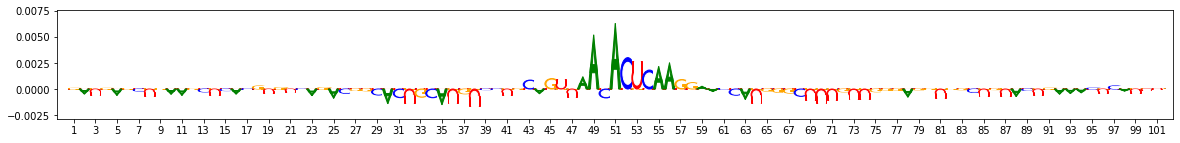

ISM:


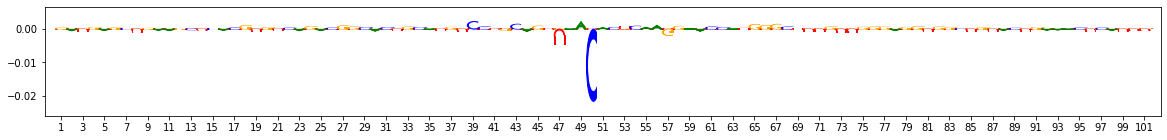

True edit rate: 0.0
Predicted edit rate: 0.013714611530303955
DeepSHAP:


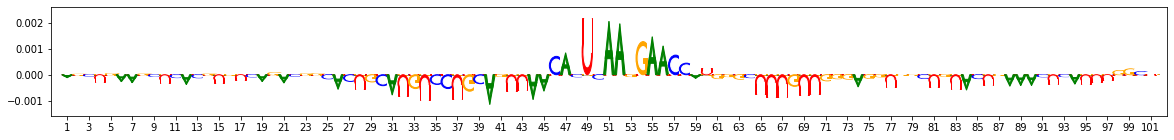

ISM:


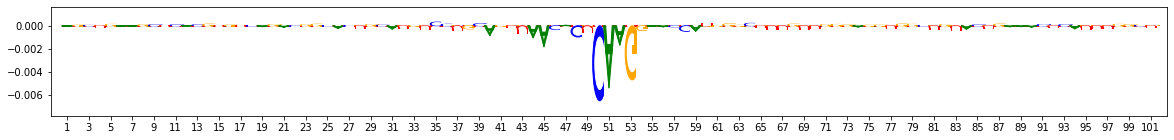

True edit rate: 0.0
Predicted edit rate: 0.005148977041244507
DeepSHAP:


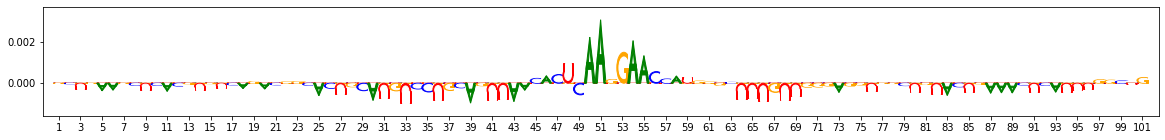

ISM:


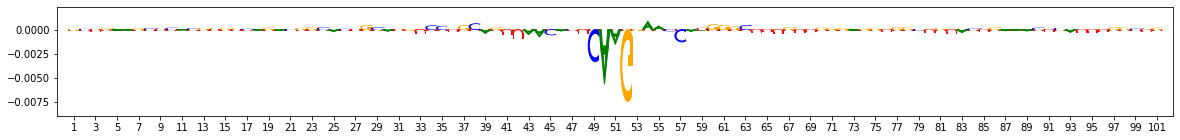

True edit rate: 0.0357
Predicted edit rate: 0.005952298641204834
DeepSHAP:


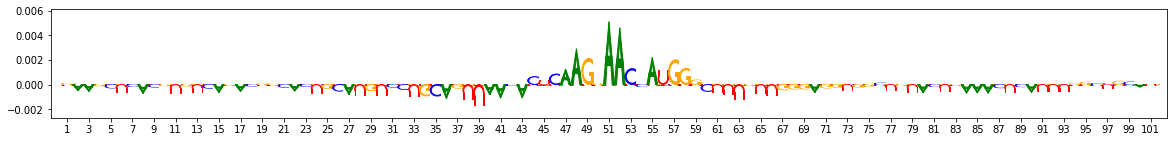

ISM:


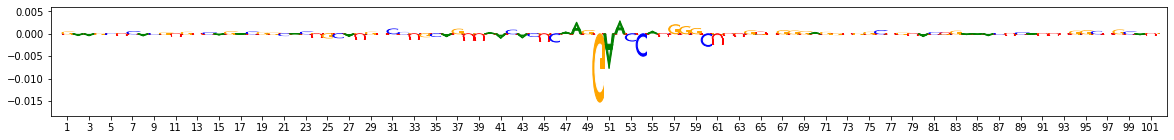

True edit rate: 0.0
Predicted edit rate: 0.012531459331512451
DeepSHAP:


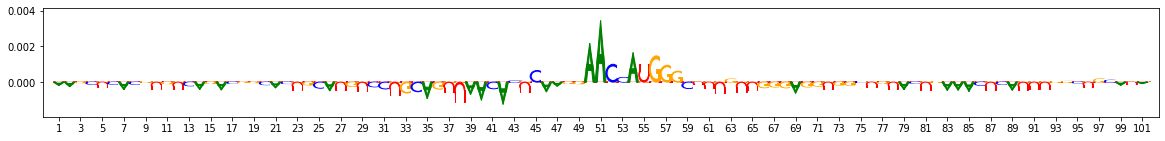

ISM:


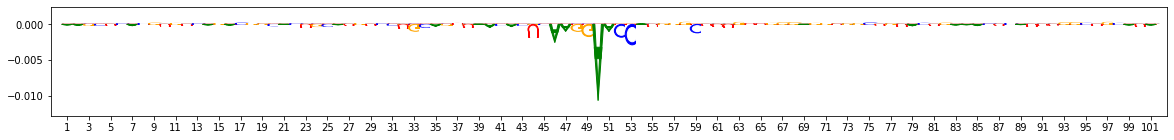

True edit rate: 0.0
Predicted edit rate: 0.005946457386016846
DeepSHAP:


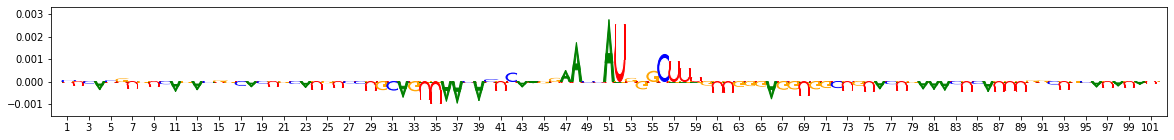

ISM:


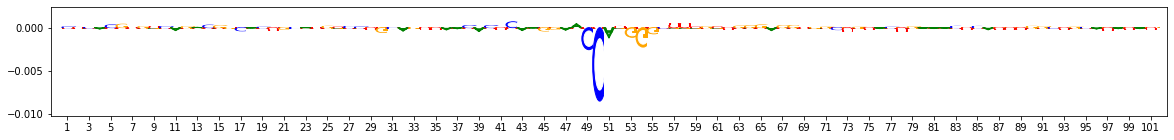

True edit rate: 0.0
Predicted edit rate: 0.0052817463874816895
DeepSHAP:


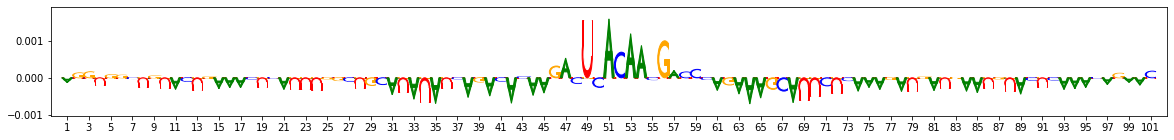

ISM:


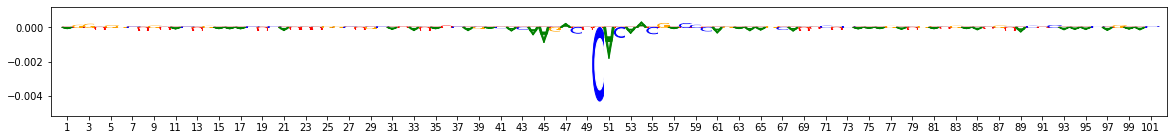

True edit rate: 0.0192
Predicted edit rate: 0.004398941993713379
DeepSHAP:


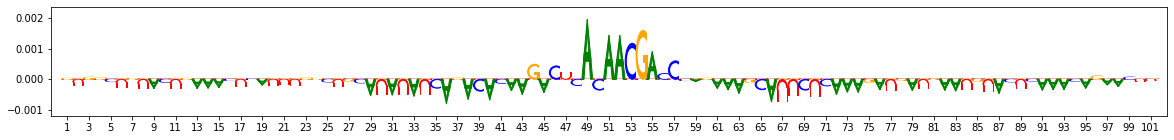

ISM:


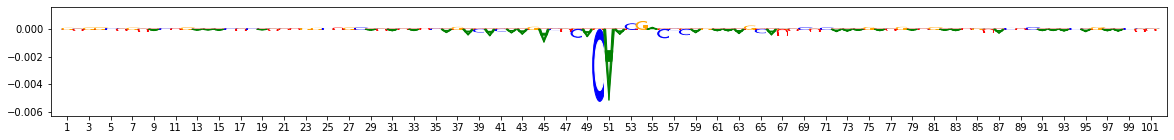

True edit rate: 0.0
Predicted edit rate: 0.0038589835166931152
DeepSHAP:


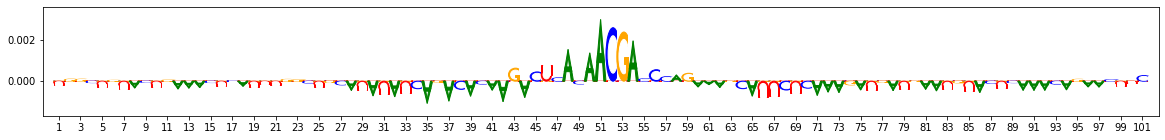

ISM:


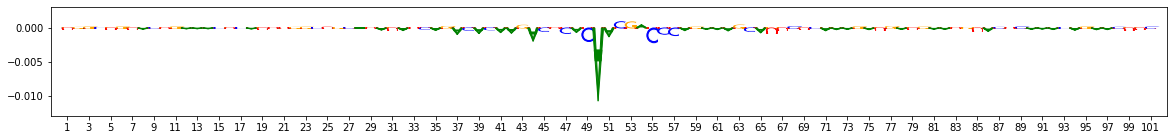

True edit rate: 0.0
Predicted edit rate: 0.004755526781082153
DeepSHAP:


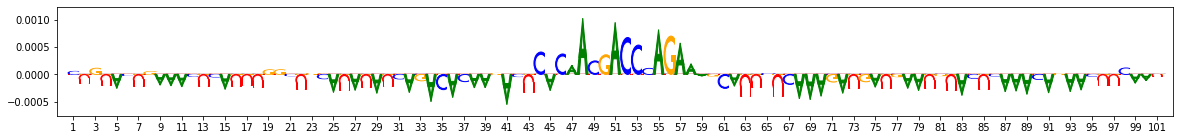

ISM:


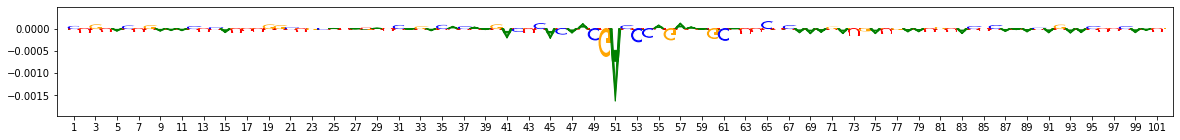

True edit rate: 0.0
Predicted edit rate: 0.0038126111030578613


In [31]:
preds = model.predict(validation_generator[n][0])
for x in range(10): 
    print("DeepSHAP:")
    rna_plot_weights(shap_values[0][x][:,0:4]* validation_generator[n][0][x])
    print("ISM:")
    rna_plot_weights(res[x])
    print("True edit rate: {}".format(validation_generator[n][1][x]))
    print("Predicted edit rate: {}".format(preds[x][0]))